In [1]:
from pathlib import Path
import scipy.sparse as sp
from scipy.sparse import coo_matrix, csr_matrix
from scipy.sparse.csgraph import shortest_path, laplacian as sp_laplacian
from scipy.spatial.distance import cdist
import numpy as np
import open3d as o3d
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import trimesh
import ot
import ot.plot

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
import sys
sys.path.append('../code')
import FOT

In [3]:
TRAIN_PATH = Path('MPI-FAUST/training/registrations')

In [4]:
def load_ply_mesh(p):
    """
    p: Path to .ply
    return: (V, F) with V:(n,3) float64, F:(m,3) int
    """
    m = trimesh.load_mesh(str(p), process=False)
    # trimesh는 faces가 (m,3), vertices가 (n,3)
    V = np.asarray(m.vertices, dtype=np.float64)
    F = np.asarray(m.faces, dtype=np.int32)
    return V, F

def to_mesh(V, F, colors=None):
    mesh = o3d.geometry.TriangleMesh(
        o3d.utility.Vector3dVector(V),
        o3d.utility.Vector3iVector(F)
    )
    mesh.compute_vertex_normals()
    if colors is not None:
        mesh.vertex_colors = o3d.utility.Vector3dVector(colors)
    return mesh

def transfer_colors_soft(T, colors_src): 
    w = T.sum(0, keepdims=True) + 1e-12 
    colors_t = (T.T @ colors_src) / w.T 
    return np.clip(colors_t, 0, 1) 

def build_adj_from_mesh(V: np.ndarray, F: np.ndarray) -> csr_matrix:
    """
    V: (n, 3) vertices
    F: (m, 3) faces (triangle indices, int)
    return: sparse (n, n) weighted adjacency, weight = edge length
    """
    n = V.shape[0]
    i0, i1, i2 = F[:, 0], F[:, 1], F[:, 2]

    edges = np.vstack([
        np.stack([i0, i1], axis=1),
        np.stack([i1, i2], axis=1),
        np.stack([i2, i0], axis=1),
    ])

    # make it undirected
    edges = np.vstack([edges, edges[:, ::-1]])

    p0 = V[edges[:, 0]]
    p1 = V[edges[:, 1]]
    lengths = np.linalg.norm(p0 - p1, axis=1)

    A = coo_matrix((lengths, (edges[:, 0], edges[:, 1])), shape=(n, n))
    return A.tocsr()

def compute_fpfh_from_mesh(
    V: np.ndarray,
    F: np.ndarray,
    normal_radius_scale: float = 0.02,
    fpfh_radius_scale: float = 0.04,
) -> np.ndarray:
    """
    open3d 기본 기능로 가능한 피처: FPFH
    return: (n, d) = (n, 33)
    """
    # mesh -> o3d
    mesh = o3d.geometry.TriangleMesh()
    mesh.vertices = o3d.utility.Vector3dVector(V)
    mesh.triangles = o3d.utility.Vector3iVector(F.astype(np.int32))
    mesh.compute_vertex_normals()

    # vertex를 point cloud로
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(V)
    pcd.normals = mesh.vertex_normals  # 있어야 FPFH가 잘 됨

    # bbox 기반으로 radius 정규화
    bbox = mesh.get_axis_aligned_bounding_box()
    diag = np.linalg.norm(
        np.array(bbox.get_max_bound()) - np.array(bbox.get_min_bound())
    )
    n_radius = normal_radius_scale * diag
    f_radius = fpfh_radius_scale * diag

    # normal은 이미 있고, 그래도 찾기 파라미터 명시
    pcd.estimate_normals(
        search_param=o3d.geometry.KDTreeSearchParamHybrid(
            radius=n_radius, max_nn=30
        )
    )

    fpfh = o3d.pipelines.registration.compute_fpfh_feature(
        pcd,
        o3d.geometry.KDTreeSearchParamHybrid(
            radius=f_radius, max_nn=100
        ),
    )
    # fpfh.data: (33, n)
    feats = np.asarray(fpfh.data).T  # (n, 33)
    return feats

# --- 1) heat kernel helper: sparse도 받게 ----
def heat_kernel_from_adj(
    A,
    t=1.0,
    lap='rw',          # 'rw' or 'sym'
    method='taylor',   # 지금은 taylor만 있다고 치자
    order=2,
    renormalize=True,
):
    """
    A : (n,n) dense or sparse adjacency
    return: (n,n) dense heat kernel
    """
    # 0. sparse면 dense로
    if sp.issparse(A):
        A = A.tocsr()

    n = A.shape[0]

    # 1. Laplacian 만들기
    if lap == 'rw':
        # random-walk L = I - D^{-1} A
        if sp.issparse(A):
            deg = np.array(A.sum(axis=1)).ravel()
            invdeg = 1.0 / np.clip(deg, 1e-12, None)
            # L_rw = I - D^{-1}A
            # dense로 할 거니까 여기서 곧 toarray
            A_dense = A.toarray()
            L = np.eye(n) - (invdeg[:, None] * A_dense)
        else:
            deg = A.sum(axis=1)
            invdeg = 1.0 / np.clip(deg, 1e-12, None)
            L = np.eye(n) - (invdeg[:, None] * A)
    else:  # 'sym'
        # symmetric Laplacian: L = D - A
        if sp.issparse(A):
            L = sp_laplacian(A, normed=False).toarray()
        else:
            deg = A.sum(axis=1)
            L = np.diag(deg) - A

    I = np.eye(n)
    if method == 'taylor':
        if order == 2:
            K = I - t * L + 0.5 * (t ** 2) * (L @ L)
        else:
            K = I - t * L
    else:
        # 필요하면 이후에 expm 넣기
        raise NotImplementedError("only taylor supported here")

    if renormalize:
        K = K / (K.sum(1, keepdims=True) + 1e-12)
    return K


# --- 2) diffusion distance (dense K만 받으면 됨) ----
def diffusion_distance_matrix(K, pi=None):
    """
    K : (n,n) heat kernel, rows ~ distributions
    pi: (n,) stationary approx
    """
    n = K.shape[0]
    if pi is None:
        # row-average로 proxy
        pi = K.mean(axis=0)
    pi = np.asarray(pi, dtype=float).reshape(-1)
    pi = pi / np.clip(pi.sum(), 1e-12, None)

    W = np.diag(1.0 / np.sqrt(pi + 1e-12))

    X = K @ W
    sqnorm = np.sum(X * X, axis=1, keepdims=True)
    G = X @ X.T
    D2 = np.clip(sqnorm + sqnorm.T - 2 * G, 0.0, None)
    return np.sqrt(D2)


# --- 3) RKHS distance from kernel (dense) ----
def rkhs_distance_matrix_from_kernel(K, force_sym=True):
    if force_sym:
        K = 0.5 * (K + K.T)
    diag = np.diag(K).reshape(-1, 1)
    D2 = np.clip(diag + diag.T - 2.0 * K, 0.0, None)
    return np.sqrt(D2)


# --- 4) sparse A에서도 한 번에 두 거리 뽑는 wrapper ----
def diffusion_and_rkhs_distances(
    A, t=1.0, method='taylor', order=2, pi=None
):
    """
    A : (n,n) dense or sparse adjacency
    Returns:
      D_diff : diffusion distance (from RW heat kernel)
      D_rkhs : RKHS distance (from sym heat kernel)
    """
    # diffusion: RW
    K_rw = heat_kernel_from_adj(
        A, t=t, lap='rw', method=method, order=order, renormalize=True
    )
    D_diff = diffusion_distance_matrix(K_rw, pi=pi)

    # RKHS: symmetric
    K_sym = heat_kernel_from_adj(
        A, t=t, lap='sym', method=method, order=order, renormalize=False
    )
    D_rkhs = rkhs_distance_matrix_from_kernel(K_sym, force_sym=True)

    return D_diff, D_rkhs


# --- 5) geodesic도 sparse 받아서 처리 ----
def all_pairs_geodesic(A, weighted=False):
    """
    A : dense or sparse adjacency
    """
    if sp.issparse(A):
        G = A
    else:
        G = sp.csr_matrix(A if weighted else (A > 0).astype(float))
    D = shortest_path(G, directed=False, unweighted=not weighted)
    return D


# --- 6) (참고) block feature는 원래 sparse랑 무관해서 그대로 ----
def make_block_features(z, d=6, margin=2.0, noise=0.5, rng=None):
    if rng is None:
        rng = np.random.default_rng()

    B = z.max() + 1
    mu = np.zeros((B, d))
    for b in range(B):
        mu[b, b % d] = margin
    FX = mu[z] + noise * rng.standard_normal((len(z), d))
    return FX, mu

# 사용 가능한 파일 확인
files = sorted(TRAIN_PATH.glob("*.ply"))
# print(f"#files: {len(files)}")
# if files[:3]: 
#     for f in files[:3]:
#         print("e.g.", f.name)

In [124]:
V_s, F_s = load_ply_mesh(files[20])
V_t, F_t = load_ply_mesh(files[30])
n_s, n_t = len(V_s), len(V_t)
a = b = np.ones((n_s,)) / n_s

colors_src = (V_s - V_s.min(0)) / (V_s.max(0) - V_s.min(0) + 1e-12)
mesh_src = to_mesh(V_s, F_s, colors_src)

A_s = build_adj_from_mesh(V_s,F_s)
A_t = build_adj_from_mesh(V_t,F_t)

# f_s = compute_fpfh_from_mesh(V_s,F_s)
# f_t = compute_fpfh_from_mesh(V_t,F_t)

In [125]:
t_heat = 1

# Ds_sym = heat_kernel_from_adj(A_s, t=t_heat, lap='sym', method='taylor', order=2)
# Dt_sym = heat_kernel_from_adj(A_t, t=t_heat, lap='sym', method='taylor', order=2)

# Ds = rkhs_distance_matrix_from_kernel(Ds_sym) 
# Dt = rkhs_distance_matrix_from_kernel(Dt_sym)
Ds = all_pairs_geodesic(A_s)
Dt = all_pairs_geodesic(A_t)

In [126]:
# C_ff = cdist(f_s, f_t, metric="sqeuclidean")
C_f = cdist(V_s, V_t, metric="sqeuclidean")

In [127]:
def random_coupling_with_marginals(p, q, max_iter=1000, tol=1e-9, seed=None):
    rng = np.random.default_rng(seed)
    K = rng.random((len(p), len(q)))
    u = np.ones_like(p)
    v = np.ones_like(q)
    for _ in range(max_iter):
        u_prev = u.copy()
        u = p / (K @ v)
        v = q / (K.T @ u)
        if np.linalg.norm(u - u_prev, 1) < tol:
            break
    P = np.diag(u) @ K @ np.diag(v)
    P /= P.sum()  # optional normalization
    return P

# pi = random_coupling_with_marginals(a,b)
pi = np.outer(a,b)

In [128]:
import time

alpha = 0.85
T = 10

start_time = time.time()  # 시작 시간 기록

model = FOT.ConvexFusedTransport(
    alpha=alpha,
    fw_max_iter=T,
    fw_stepsize='classic',
    tol=1e-40,
    lmo_method='emd',
    pre_Cf=C_f,
    pre_DX=Ds,
    pre_DY=Dt,
    normalize=True,
    verbose=2
).fit(
    X=np.array(range(n_s)).reshape(-1, 1),
    Y=np.array(range(n_t)).reshape(-1, 1),
    FX=None, FY=None, init=pi,
    return_hard_assignment=True
)

end_time = time.time()  # 종료 시간 기록
elapsed = end_time - start_time

print(f"\nTotal runtime: {elapsed:.3f} seconds")

[Iter 001] gap=4.168e-02 obj_feat=2.868e-02 obj_struct=8.259e-03
[Iter 002] gap=1.696e-02 obj_feat=1.105e-02 obj_struct=3.267e-03
[Iter 003] gap=1.031e-02 obj_feat=6.631e-03 obj_struct=2.162e-03
[Iter 004] gap=6.810e-03 obj_feat=4.747e-03 obj_struct=1.519e-03
[Iter 005] gap=4.987e-03 obj_feat=3.732e-03 obj_struct=1.131e-03
[Iter 006] gap=3.810e-03 obj_feat=3.073e-03 obj_struct=8.373e-04
[Iter 007] gap=2.950e-03 obj_feat=2.611e-03 obj_struct=6.209e-04
[Iter 008] gap=2.278e-03 obj_feat=2.265e-03 obj_struct=4.678e-04
[Iter 009] gap=1.916e-03 obj_feat=2.009e-03 obj_struct=3.725e-04
[Iter 010] gap=1.514e-03 obj_feat=1.807e-03 obj_struct=2.981e-04
Optimization finished.

Total runtime: 730.952 seconds


In [141]:
alpha = 0.2

T_FGW = ot.gromov.fused_gromov_wasserstein(
    C_f, Ds, Dt, G_0=pi,
    alpha=alpha, loss_fun='square_loss'
)

## Diagnosis

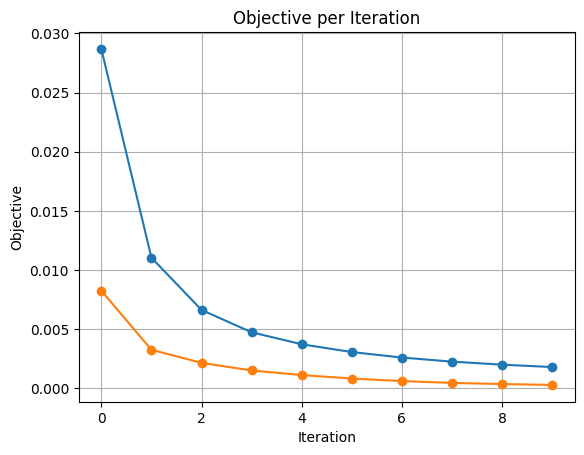

In [142]:
plt.plot(range(len(model.obj_history_)), model.obj_history_, marker='o')
plt.xlabel('Iteration')
plt.ylabel('Objective')
plt.title('Objective per Iteration')
plt.grid(True)
plt.show()

In [143]:
colors_FOT = transfer_colors_soft(model.P_, colors_src) 
mesh_FOT = to_mesh(V_t, F_t, colors_FOT)

offset = np.array([1.2*V_s[:, 0].ptp(), 0, 0])
mesh_FOT.translate(offset)

# o3d.visualization.draw_geometries([mesh_src,mesh_FOT])

colors_FGW = transfer_colors_soft(T_FGW, colors_src) 
mesh_FGW = to_mesh(V_t, F_t, colors_FGW)

offset = np.array([2.4*V_s[:, 0].ptp(), 0, 0])
mesh_FGW.translate(offset)

o3d.visualization.draw_geometries([mesh_src,mesh_FOT,mesh_FGW])

In [144]:
import numpy as np

def transfer_target_by_source_deformation(
    V_s1, F_s1,
    V_s2, F_s2,
    V_t1, F_t1,
    pi, eps=1e-12
):
    """
    F_*는 (n_s, d_f) / (n_t, d_f) 꼴의 'vertex-wise feature'일 때만 처리한다.
    mesh faces (m, 3) 같은 건 자동으로 스킵한다.
    """
    # 1) vertex 변위
    dV_s = V_s2 - V_s1                      # (n_s, d_v)
    w_t = pi.sum(axis=0, keepdims=True)     # (1, n_t)

    # vertex pushforward
    dV_t_num = dV_s.T @ pi                  # (d_v, n_t)
    dV_t = (dV_t_num / (w_t + eps)).T       # (n_t, d_v)
    V_t2 = V_t1 + dV_t

    return V_t2


In [145]:
pi = T_FGW
# pi = model.pi_
# pi = np.outer(a,b) * (n_s**2)

V_s2, F_s2 = load_ply_mesh(files[27])
V_t2, F_t2 = load_ply_mesh(files[37])

V_t2_pred = transfer_target_by_source_deformation(
    V_s1=V_s, F_s1=F_s,
    V_s2=V_s2, F_s2=F_s2,
    V_t1=V_t, F_t1=F_t,
    pi=pi
)

mesh_trans = to_mesh(V_t2_pred,F_t)
o3d.visualization.draw_geometries([mesh_trans])

### 끼워맞추자

In [16]:
# V,F = load_ply_mesh(files[50])

# colors = (V - V.min(0)) / (V.max(0) - V.min(0) + 1e-12)
# mesh = to_mesh(V, F, colors)

# o3d.visualization.draw_geometries([mesh])

In [119]:
V_t2_pred == V_t

array([[False, False, False],
       [False, False, False],
       [False, False, False],
       ...,
       [False, False, False],
       [False, False, False],
       [False, False, False]])